# k-NN Few-shot classification w/ GPT on Persuasive Essays

## "All-in-one" approach

In [70]:
import os
import copy
import json
import time
import pickle
import random
from operator import itemgetter

import openai
import tiktoken
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from openai.embeddings_utils import get_embedding
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from dotenv import load_dotenv

plt.style.use('ggplot')

%matplotlib inline

In [3]:
load_dotenv(verbose=True)

True

#### OpenAI Set-up

In [4]:
openai.api_type = "azure"
openai.api_base = "https://your.endpoint.url.com/"
openai.api_version = "2023-07-01-preview"
openai.api_key = os.getenv("OPENAI_KEY")  # This key should be in a local .env file

ENGINE_NAME='gpt-4'
EMBEDDING_ENGINE_NAME='ada-2'

In [ ]:
df = pd.read_csv(os.path.join('data', 'pe_dataset.csv'))

#### Embed all essay titles

In [ ]:
title_embed_d = {}
for title in df.title.unique():
    print(title)
    while True:
        try:
            a = np.array(get_embedding(title, engine=EMBEDDING_ENGINE_NAME))
            title_embed_d[title] = a
            break
        except Exception as e:
            print(e)
            time.sleep(1)

In [5]:
df['title_embedding'] = df.title.apply(lambda x: title_embed_d[x])

In [6]:
df

,split,title,argument_bound_1,argument_bound_2,argument_id,ac,label,essay,title_embedding
0,TRAIN,Should students be taught to compete or to coo...,503,575,1,we should attach more importance to cooperatio...,MajorClaim,Should students be taught to compete or to coo...,"[-0.017197363078594208, -0.0013341084122657776..."
1,TRAIN,Should students be taught to compete or to coo...,591,714,2,"through cooperation, children can learn about ...",Claim,Should students be taught to compete or to coo...,"[-0.017197363078594208, -0.0013341084122657776..."
2,TRAIN,Should students be taught to compete or to coo...,716,851,3,What we acquired from team work is not only ho...,Premise,Should students be taught to compete or to coo...,"[-0.017197363078594208, -0.0013341084122657776..."
3,TRAIN,Should students be taught to compete or to coo...,853,1086,4,"During the process of cooperation, children ca...",Premise,Should students be taught to compete or to coo...,"[-0.017197363078594208, -0.0013341084122657776..."
4,TRAIN,Should students be taught to compete or to coo...,1088,1191,5,All of these skills help them to get on well w...,Premise,Should students be taught to compete or to coo...,"[-0.017197363078594208, -0.0013341084122657776..."
...,...,...,...,...,...,...,...,...,...
6084,TRAIN,Children should studying hard or playing sport...,1275,1339,11,indirectly they will learn how to socialize ea...,Premise,Children should studying hard or playing sport...,"[-0.004262133967131376, 0.01529134064912796, 0..."
6085,TRAIN,Children should studying hard or playing sport...,1341,1388,12,That will make children getting lots of friends,Premise,Children should studying hard or playing sport...,"[-0.004262133967131376, 0.01529134064912796, 0..."
6086,TRAIN,Children should studying hard or playing sport...,1393,1436,13,they can contribute positively to community,Premise,Children should studying hard or playing sport...,"[-0.004262133967131376, 0.01529134064912796, 0..."
6087,TRAIN,Children should studying hard or playing sport...,1448,1525,14,playing sport makes children getting healthy a...,Premise,Children should studying hard or playing sport...,"[-0.004262133967131376, 0.01529134064912796, 0..."


In [11]:
def get_k_neighbours(k, title, df):

    title_embed_d = {}
    for e in df.iterrows():
        if e[1].title not in title_embed_d:
            title_embed_d[e[1].title] = e[1].title_embedding

    train_titles = set(df[df.split == 'TRAIN'].title.unique())

    dist_l = []
    for t, v in title_embed_d.items():
        if t in train_titles:
            d = cosine(title_embed_d[title], v)
            dist_l.append((t, d))

    sorted_dist_l = sorted(dist_l, key=itemgetter(1))
    
    return sorted_dist_l[: k]

##### Test: Given a random title, fetch the 3 most similar titles.

In [34]:
get_k_neighbours(3, 'Detailed description of crimes on newspaper and TV can have bad consequences on society', df)

[('Large amount of violence in television programs', 0.13445186701270984),
 ('TV has adverse effects on friends and family', 0.1376546350015473),
 ('Television and Movies influence our lives both negatively and positively',
  0.14467761331309636)]

In [35]:
def prepare_similar_example_prompts(title, k=5, seed=33):
    """
    Create a part of prompt made of k examples in the train set, whose topic is most similar to a given title.
    """

    random.seed(seed)

    neighbours_l = get_k_neighbours(2*k, title, df) # Fetch the 2*k closest neighbors
    sampled_neighbours_l = random.sample(neighbours_l, k) # Only keep k of them
    
    prompt = ''
    cnt = 0
    for i, (title, dist) in enumerate(sampled_neighbours_l):
        prompt += f'### Example\n'

        example_df = df[(df.split == 'TRAIN') & (df.title == title)]

        class_l = []
        for k in example_df.iterrows():

            # Write the full essay
            if k[1].argument_id == 1:
                prompt += f'Essay:\n{example_df.iloc[0].essay}\n\nArguments:\n'
                cnt = 0

            # Write the current AC
            prompt += f'Argument {cnt + 1}={k[1].ac}\n'
            class_l.append(k[1].label)
            cnt += 1

        # Now write the labels in JSON format
        prompt += '\n### Result:\n'
        prompt += '{' + ', '.join([f'"Argument {i + 1}": "{class_l[i]}"' for i in range(len(class_l))]) + '}'
        prompt += '\n\n'

    return prompt

##### Test: Print 3 similar examples passed to the prompt for essay 'Living and studying overseas'

In [36]:
print(prepare_similar_example_prompts('Living and studying overseas', k=3, seed=32))

### Example
Essay:
Living in big cities or living in small towns

Continuous technological and economical development in modern world created great differences between cities, a difference that is clearly visible in the size of various cities. From cities with more that 20 million people to small towns inhabited by only hundreds of people. This diversities in cities allowed for more difference in people's preferences for where to live. For me, I prefer to live in bigger cities than in small ones, this personal attitude is the result of many factors.
First of all, I find the excitement of big cities to be attractive, living in a dynamic environment can turn into a very rich experience that sharpens one's personality and open one's eyes on the real world. Life in big cities cities gives one new challenges every day, let it be deciding which restaurant to go to or deciding which company to work for. For me, this lifestyles is very attractive and is considered a huge advantage of big citie

### Prepare system/user messages for all essays in test set

In [17]:
majorclaim_fulldesc = """The major claim represents the stance of the author about the essay topic. It is also called thesis statement and frequently indicated by opinion expressions like “From my point of view...”, “In my opinion...”, “I strongly believe that...”, etc. Usually, the major claim is present in the introduction or conclusion of an essay or in both. In the introduction it has the characteristics of a general assertion or an opinion with respect to the topic, whereas in the conclusion the major claim summarizes the argumentation according to the author’s stance."""

In [18]:
claim_fulldesc = "A claim in an body paragraph is the central component of an argument. It appears frequently as an initial assumption located at the beginning of a paragraph or as a conclusion near the end. In few cases, the claim might also be located somewhere between the statements of a paragraph. Most frequently, one paragraph includes a single unique claim and there are only few cases where several claims/arguments are included in a single body paragraph. In this case, a paragraph includes several arguments covering different topics or aspects related to the topic."

In [19]:
premise_fulldesc = "A premise is a reason given for supporting or attacking an argument component. So it can be considered as a justification or refutation for convincing the reader of the truth or falsity of a claim."

In [20]:
df[df.split == 'TRAIN'].label.value_counts(normalize=True)

label
Premise       0.626788
Claim         0.249222
MajorClaim    0.123989
Name: proportion, dtype: float64

In [21]:
proportion_desc = "62.7% of examples are of type Premise, 24.9% of type Claim, and 12.4% of type MajorClaim."

In [22]:
%%time

experiment_df = df[df.split == 'TEST']

target_l = []

# Pre-prepare all examples from each document
title_l = []
essay_l = []
example_l = []
buffer_l = []
label_l = []
for e in experiment_df.iterrows():

    if e[1].argument_id == 1:
        essay_l.append(e[1].essay)
        title_l.append(e[1].title)
    
    if e[1].argument_id == 1 and len(buffer_l) > 0:
        example_l.append(buffer_l)
        target_l.append(label_l)
        buffer_l = []
        label_l = []

    buffer_l.append(e[1].ac)
    label_l.append(e[1].label)

# Flush the buffers
example_l.append(buffer_l)
target_l.append(label_l)


sys_msg_l_by_seed_d = {}
task_msg_l = []

for i in range(len(example_l)):

    # Prepare numbered list of ACs in this example
    other_acs_prompt = ''
    for j, s in enumerate(example_l[i]):
        other_acs_prompt += f'Argument {j + 1}={s}\n'

    for seed in [33, 34, 35, 36, 37]:
        sys_msg = {"role":"system", "content": "### Task description: You are an expert assistant that takes 1) an essay, 2) the list of all arguments from this essay, and must classify all arguments into three classes: MajorClaim, Claim, and Premise. " + proportion_desc + " You must return a JSON with format {\"Argument 1\": <predicted class for Argument 1 (str)>, ..., \"Argument n\": <predicted class for Argument n (str)>}\n\n### Class definitions:\nMajorClaim=" + majorclaim_fulldesc + "\n\nClaim=" + claim_fulldesc + "\n\nPremise=" + premise_fulldesc + "\n\n" + prepare_similar_example_prompts(title_l[i], k=5, seed=seed)}  # Sample by similar title

        try:
            sys_msg_l_by_seed_d[seed].append(sys_msg)
        except KeyError:
            sys_msg_l_by_seed_d[seed] = [sys_msg]

    task_msg = {"role":"user", "content": f"Essay:\n{essay_l[i]}\n\nArguments:\n{other_acs_prompt}"}
    
    task_msg_l.append(task_msg)

CPU times: user 1min 5s, sys: 72.6 ms, total: 1min 5s
Wall time: 1min 5s


#### Run GPT on these messages

In [ ]:
%%time

prediction_d_l = []

for i in range(len(task_msg_l)):

    print(i, len(task_msg_l))

    ensemble_l = []
    for seed in sys_msg_l_by_seed_d.keys():  # Ensemble that stuff
    
        # MAIN TASK
        while True:
    
            try:
    
                response = openai.ChatCompletion.create(
                  engine=ENGINE_NAME,
                  messages = [sys_msg_l_by_seed_d[seed][i], task_msg_l[i]],
                  temperature=0.0,  # We want low temperature for classification
                  max_tokens=400,
                  top_p=0.1,
                  frequency_penalty=0,
                  presence_penalty=0,
                  stop=None)
    
                prediction = response['choices'][0]['message']['content']
                print(prediction)
                if prediction.startswith('### Result:'):
                    prediction = prediction.split('### Result:')[1].strip()
                    print('Cleaned prediction: ', prediction)
                
                prediction_d = json.loads(prediction)
                ensemble_l.append(prediction_d)
    
                time.sleep(1)
    
                break
    
            except Exception as e: # Retry until you get the result
                print(e)
                time.sleep(5)

    prediction_d_l.append(ensemble_l)
    print(len(ensemble_l), len(prediction_d_l))

#### Extract/align all ground truths and predictions

In [266]:
unrolled_target_l = []
unrolled_predictions_l = []

for i in range(min(len(prediction_d_l), len(target_l))):
    predicted_sub_l = []

    predicted_sub_d = {}
    for seed_results_d in prediction_d_l[i]:
        for j in range(len(seed_results_d)):
            try:
                predicted_sub_d[j].append(seed_results_d[f"Argument {j + 1}"])
            except KeyError:
                predicted_sub_d[j] = [seed_results_d[f"Argument {j + 1}"]]

    print(predicted_sub_d)

    # Get the majority vote
    for j in range(len(predicted_sub_d)):
        mode_pred = max(set(predicted_sub_d[j]), key=predicted_sub_d[j].count)
        predicted_sub_l.append(mode_pred)


    print('Pred:', predicted_sub_l)
    print('Actu:', target_l[i])

    unrolled_predictions_l.extend(predicted_sub_l)
    unrolled_target_l.extend(target_l[i])

{0: ['Premise', 'Premise', 'Premise', 'Premise', 'Claim'], 1: ['MajorClaim', 'MajorClaim', 'MajorClaim', 'MajorClaim', 'MajorClaim'], 2: ['Claim', 'Premise', 'Claim', 'Claim', 'Premise'], 3: ['Premise', 'Premise', 'Premise', 'Premise', 'Premise'], 4: ['Premise', 'Premise', 'Premise', 'Premise', 'Premise'], 5: ['Claim', 'Claim', 'Premise', 'Claim', 'Claim'], 6: ['Claim', 'Premise', 'Claim', 'Claim', 'Premise'], 7: ['Premise', 'Premise', 'Premise', 'Premise', 'Premise'], 8: ['Premise', 'Premise', 'Premise', 'Premise', 'Premise'], 9: ['Claim', 'Claim', 'Premise', 'Claim', 'Claim'], 10: ['MajorClaim', 'MajorClaim', 'MajorClaim', 'MajorClaim', 'MajorClaim']}
Pred: ['Premise', 'MajorClaim', 'Claim', 'Premise', 'Premise', 'Claim', 'Claim', 'Premise', 'Premise', 'Claim', 'MajorClaim']
Actu: ['Claim', 'MajorClaim', 'Premise', 'Premise', 'Premise', 'Claim', 'Premise', 'Premise', 'Premise', 'Claim', 'MajorClaim']
{0: ['MajorClaim', 'MajorClaim', 'MajorClaim', 'MajorClaim', 'MajorClaim'], 1: ['Cla

### Classification performance on the test set

In [268]:
print(classification_report(unrolled_target_l, unrolled_predictions_l, digits=3))

              precision    recall  f1-score   support

       Claim      0.689     0.707     0.698       304
  MajorClaim      0.894     0.935     0.914       153
     Premise      0.906     0.889     0.897       809

    accuracy                          0.851      1266
   macro avg      0.829     0.844     0.836      1266
weighted avg      0.852     0.851     0.851      1266



### Calculate number of tokens used with this approach

In [41]:
# Adapted from
# https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb

def num_tokens_from_messages(messages, encoding, model_name):

    if model_name in {
        "gpt-3.5-turbo-0613",
        "gpt-3.5-turbo-16k-0613",
        "gpt-4-0314",
        "gpt-4-32k-0314",
        "gpt-4-0613",
        "gpt-4-32k-0613",
        }:
        tokens_per_message = 3
        tokens_per_name = 1
    elif model_name == "gpt-3.5-turbo-0301":
        tokens_per_message = 4  # every message follows <|start|>{role/name}\n{content}<|end|>\n
        tokens_per_name = -1  # if there's a name, the role is omitted
    elif "gpt-3.5-turbo" in model_name:
        # print("Warning: gpt-3.5-turbo may update over time. Returning num tokens assuming gpt-3.5-turbo-0613.")
        return num_tokens_from_messages(messages, encoding, model_name="gpt-3.5-turbo-0613")
    elif "gpt-4" in model_name:
        # print("Warning: gpt-4 may update over time. Returning num tokens assuming gpt-4-0613.")
        return num_tokens_from_messages(messages, encoding, model_name="gpt-4-0613")
    else:
        raise NotImplementedError(
            f"""num_tokens_from_messages() is not implemented for model {model}. See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens."""
        )

    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
    return num_tokens

In [42]:
encoding = tiktoken.get_encoding("cl100k_base")

#### Re-create messages and count tokens

In [77]:
%%time

experiment_df = df[df.split == 'TEST']

target_l = []

# Pre-prepare all examples from each document
title_l = []
essay_l = []
example_l = []
buffer_l = []
label_l = []
for e in experiment_df.iterrows():

    if e[1].argument_id == 1:
        essay_l.append(e[1].essay)
        title_l.append(e[1].title)
    
    if e[1].argument_id == 1 and len(buffer_l) > 0:
        example_l.append(buffer_l)
        target_l.append(label_l)
        buffer_l = []
        label_l = []

    buffer_l.append(e[1].ac)
    label_l.append(e[1].label)

# Flush the buffers
example_l.append(buffer_l)
target_l.append(label_l)

token_consumption_by_example_number_d = {}

for k in range(1, 11, 1):
    print(f'# examples = {k}')

    token_consumption_by_example_number_d[k] = []
    for i in range(len(example_l)):
    
        # Prepare numbered list of ACs in this example
        other_acs_prompt = ''
        for j, s in enumerate(example_l[i]):
            other_acs_prompt += f'Argument {j + 1}={s}\n'

        # Prepare messages
        sys_msg = {"role":"system", "content": "### Task description: You are an expert assistant that takes 1) an essay, 2) the list of all arguments from this essay, and must classify all arguments into three classes: MajorClaim, Claim, and Premise. " + proportion_desc + " You must return a JSON with format {\"Argument 1\": <predicted class for Argument 1 (str)>, ..., \"Argument n\": <predicted class for Argument n (str)>}\n\n### Class definitions:\nMajorClaim=" + majorclaim_fulldesc + "\n\nClaim=" + claim_fulldesc + "\n\nPremise=" + premise_fulldesc + "\n\n" + prepare_similar_example_prompts(title_l[i], k=k, seed=k)}  # Sample by similar title
        task_msg = {"role":"user", "content": f"Essay:\n{essay_l[i]}\n\nArguments:\n{other_acs_prompt}"}

        # Count their tokens
        n_toks = num_tokens_from_messages([sys_msg, task_msg], encoding, model_name="gpt-4")

        token_consumption_by_example_number_d[k].append(n_toks)



# examples = 1
# examples = 2
# examples = 3
# examples = 4
# examples = 5
# examples = 6
# examples = 7
# examples = 8
# examples = 9
# examples = 10
CPU times: user 2min 16s, sys: 245 ms, total: 2min 17s
Wall time: 2min 26s


In [78]:
def get_95_conf_int(data_l):

    mean_value = np.mean(data_l)

    confidence = 0.95
    z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
    ci_length = z_value * np.std(data_l)/np.sqrt(len(data_l))

    return mean_value, ci_length

##### Mean/standard error of num. tokens for 1-shot VS 2-shot 

In [79]:
get_95_conf_int(token_consumption_by_example_number_d[1])

(1972.7, 47.46531423814008)

In [80]:
get_95_conf_int(token_consumption_by_example_number_d[2])

(2789.525, 53.37840756490446)

##### Mean/standard error of num. tokens for 1 to 10-shot

In [81]:
token_consumption_l = []
for k, l in token_consumption_by_example_number_d.items():
    m, se = get_95_conf_int(l)
    token_consumption_l.append((k, m, se))

In [82]:
token_consumption_df = pd.DataFrame(token_consumption_l)

In [83]:
token_consumption_df.columns = ['# Examples', 'Avg number of input tokens', 'Standard error']

In [84]:
token_consumption_df

,# Examples,Avg number of input tokens,Standard error
0,1,1972.7000,47.465314
1,2,2789.5250,53.378408
2,3,3694.3875,69.075667
3,4,4542.2500,80.117855
4,5,5458.5625,100.006951
5,6,6304.9125,105.568900
6,7,7120.6500,91.172856
7,8,7982.5875,115.293896
8,9,8888.2625,118.304248
9,10,9675.4500,137.985375


In [85]:
print(token_consumption_df.to_markdown(index=None))

|   # Examples |   Avg number of input tokens |   Standard error |
|-------------:|-----------------------------:|-----------------:|
|            1 |                      1972.7  |          47.4653 |
|            2 |                      2789.53 |          53.3784 |
|            3 |                      3694.39 |          69.0757 |
|            4 |                      4542.25 |          80.1179 |
|            5 |                      5458.56 |         100.007  |
|            6 |                      6304.91 |         105.569  |
|            7 |                      7120.65 |          91.1729 |
|            8 |                      7982.59 |         115.294  |
|            9 |                      8888.26 |         118.304  |
|           10 |                      9675.45 |         137.985  |


<Axes: >

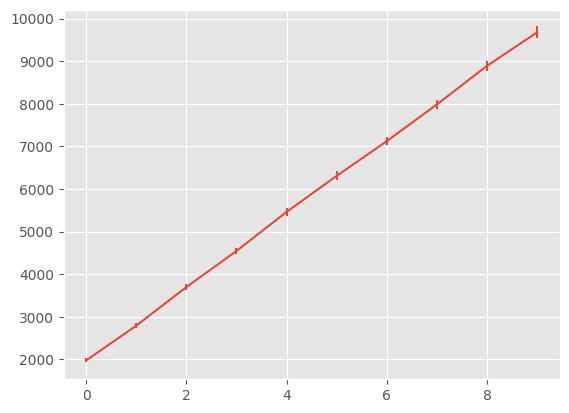

In [86]:
token_consumption_df[token_consumption_df.columns[1]].plot(yerr=token_consumption_df[token_consumption_df.columns[2]])